In [8]:
general_filename

'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_bng_regridded_12km/01/AreaWeighted/1980_2001/bng_rg_pr_rcp85_land-cpm_uk_2.2km_01_1hr_1981*'

In [20]:
##################################################################
# This Script:
#    - 
#    -
#    -

##################################################################
import iris
import os
import glob as sir_globington_the_file_gatherer
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import time
import multiprocessing as mp
import iris.plot as iplt

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

trim_to_leeds = False

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})
##################################################################

# Constraint to only load 
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

yrs_range = "1980_2001"
yrs= range(1981,2002)
resolution = '2.2km_bng_regridded_12km' #2.2km, 12km, 2.2km_regridded_12km
regridding_style = 'AreaWeighted'

### Establish the ensemble members
# ems = [ '07', '08', '09', '10', '11', '12', '13','15']
ems = ['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']
for em in ems:
    
    if resolution == '2.2km_bng_regridded_12km':
        ddir = f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{regridding_style}/{yrs_range}/{em}/"
    else:
        ddir = f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/{em}/"

    if not os.path.isdir(ddir):
        os.makedirs(ddir)
        
    print(em, resolution, trim_to_leeds)
    for yr in yrs:
        print(em, yr)

        # ### Get a list of filenames for this ensemble member, for just JJA
        if resolution == '2.2km':
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
        
        elif resolution == '12km':
              general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
        
        elif resolution == '2.2km_regridded_12km' and regridding_style == 'NearestNeighbour':
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{regridding_style}/{yrs_range}/rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
        
        elif resolution == '2.2km_regridded_12km' and regridding_style == 'AreaWeighted':
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{regridding_style}/{yrs_range}/wgs84_rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
        
        elif resolution == '2.2km_bng_regridded_12km' and regridding_style == 'AreaWeighted':
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{regridding_style}/{yrs_range}/bng_rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
    
        filenames = []
        for filename in sir_globington_the_file_gatherer.glob(general_filename):
            filenames.append(filename)
        print(f"loading {len(filenames)} files")

        # ### Load in the data
        monthly_cubes_list = iris.load(filenames, in_jja)
        print(len(monthly_cubes_list))
        
        for cube in monthly_cubes_list:
             for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
                    if attr in cube.attributes:
                        del cube.attributes[attr]

        # ### Concatenate cubes into one
        model_cube = monthly_cubes_list.concatenate_cube()      

        ### Remove ensemble member dimension
        if len(model_cube.shape)>3:
            model_cube = model_cube[0,:,:,:]
        
        ### Trim to UK
        if resolution  == '2.2km':
            model_cube = trim_to_bbox_of_region_regriddedobs(model_cube, gb_gdf)
        elif resolution =='2.2km_regridded_12km' and regridding_style == 'AreaWeighted':
            model_cube = trim_to_bbox_of_region_wgs84(model_cube, gb_gdf, 'latitude', 'longitude')
        elif resolution =='2.2km_bng_regridded_12km' and regridding_style == 'AreaWeighted':
            model_cube = trim_to_bbox_of_region_obs(model_cube, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')            
        else:
            model_cube = trim_to_bbox_of_region_obs(model_cube, gb_gdf)
        
        # ### Get the mask
        print("getting mask")
        if resolution =='2.2km':
            gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
        elif resolution =='2.2km_regridded_12km':
            gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_wgs84_GB_Mask.npy")
        elif resolution =='2.2km_bng_regridded_12km':
            gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_bng_GB_Mask.npy")
        else:
            gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
        masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]
        
        # APPLY THE MASK
        reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
        reshaped_mask = reshaped_mask.astype(int)
        reversed_array = ~reshaped_mask.astype(bool)

        # Mask the cube
        masked_cube = iris.util.mask_cube(model_cube, reversed_array)

        # ### Check the mask
        # iplt.contourf(masked_cube[10])
        # plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

        # Save
        iris.save(masked_cube, ddir + f'{yr}_maskedcube.nc')      
        
        # Check the plotting
        # iplt.contourf(masked_cube[10])
        # plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

        # Get rid of negative values
        compressed = masked_cube.data.compressed()
        compressed.shape[0]

        ########
        # Get the times
        ########
        # Step 2: Get the indices of the non-masked values in the original data
        non_masked_indices = np.where(~masked_cube.data.mask)

        # Step 3: Extract corresponding time values
        # time_values = masked_cube.coord('time').points[non_masked_indices[0]]

        # Save to file
        # np.save(ddir + f'timevalues_{yr}.npy', time_values) 
        np.save(ddir + f'compressed_{yr}.npy', compressed) 

time_values = masked_cube.coord('yyyymmddhh').points[non_masked_indices[0]]
if resolution == '2.2km_regridded_12km':
    f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{regridding_style}/{yrs_range}/timevalues.npy"
else:
    np.save(f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{regridding_style}/{yrs_range}/timevalues.npy", time_values)

04 2.2km_bng_regridded_12km False
04 1981
loading 3 files
3
getting mask
04 1982
loading 2 files
2
getting mask
04 1983
loading 3 files
3
getting mask
04 1984
loading 3 files
3
getting mask
04 1985
loading 3 files
3
getting mask
04 1986
loading 3 files
3
getting mask
04 1987
loading 3 files
3
getting mask
04 1988
loading 3 files
3
getting mask
04 1989
loading 3 files
3
getting mask
04 1990
loading 3 files
3
getting mask
04 1991
loading 3 files
3
getting mask
04 1992
loading 3 files
3
getting mask
04 1993
loading 3 files
3
getting mask
04 1994
loading 3 files
3
getting mask
04 1995
loading 3 files
3
getting mask
04 1996
loading 3 files
3
getting mask
04 1997
loading 3 files
3
getting mask
04 1998
loading 3 files
3
getting mask
04 1999
loading 3 files
3
getting mask
04 2000
loading 3 files
3
getting mask
04 2001
loading 3 files
3
getting mask
05 2.2km_bng_regridded_12km False
05 1981
loading 3 files
3
getting mask
05 1982
loading 3 files
3
getting mask
05 1983
loading 3 files
3
getting m

3
getting mask
13 1994
loading 3 files
3
getting mask
13 1995
loading 3 files
3
getting mask
13 1996
loading 3 files
3
getting mask
13 1997
loading 3 files
3
getting mask
13 1998
loading 3 files
3
getting mask
13 1999
loading 3 files
3
getting mask
13 2000
loading 3 files
3
getting mask
13 2001
loading 3 files
3
getting mask
15 2.2km_bng_regridded_12km False
15 1981
loading 3 files
3
getting mask
15 1982
loading 3 files
3
getting mask
15 1983
loading 3 files
3
getting mask
15 1984
loading 3 files
3
getting mask
15 1985
loading 3 files
3
getting mask
15 1986
loading 3 files
3
getting mask
15 1987
loading 3 files
3
getting mask
15 1988
loading 3 files
3
getting mask
15 1989
loading 3 files
3
getting mask
15 1990
loading 3 files
3
getting mask
15 1991
loading 3 files
3
getting mask
15 1992
loading 3 files
3
getting mask
15 1993
loading 3 files
3
getting mask
15 1994
loading 3 files
3
getting mask
15 1995
loading 3 files
3
getting mask
15 1996
loading 3 files
3
getting mask
15 1997
loading

### Set up environment

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [28]:
def calculate_ccdf_wetvalues(precipitation_data, bins_i_want, filter_small_vals=False):
    # Remove NAN values
    precipitation_data = precipitation_data[~np.isnan(precipitation_data)]
    # Keep only wet values 
    precipitation_data = precipitation_data[precipitation_data >= 0.1]

    # Compute the cumulative distribution function (CDF) using the histogram
    # np.diff(bin_edges): Calculate the differences between bin edges to get bin widths
    # hist * np.diff(bin_edges): Multiply each histogram value by its corresponding bin width
    # np.cumsum(): Compute the cumulative sum of the products
    # cdf: The cumulative distribution function values
    hist, bin_edges = np.histogram(precipitation_data, bins=bins_i_want, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))
    
    # Calculate 1 - CDF for CCDF
    ccdf = 1 - cdf
    
    # Find the centre point of each bin for plotting
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    return cdf, ccdf, bin_centres, bin_edges[1:]


# Function to calculate PDF from a single file
def calculate_pdf_wetvalues (precipitation_data,bins_i_want, filter_small_vals=False ):
    # Remove NAN values
    precipitation_data = precipitation_data[~np.isnan(precipitation_data)]
    # Keep only wet values 
    precipitation_data = precipitation_data[precipitation_data >= 0.1]
    
    freqs, bin_edges = np.histogram(precipitation_data, bins=bins_i_want, density=True)
    # I think this was just for knowing how many value was in each bin
    # How was I using that in log_discrete_histogram_less_legend???
    # freqs_numbers, bin_edges = np.histogram(precipitation_data, bins= bins, density=False)
    
    # Find the centre point of each bin for plotting
    bin_centres =  0.5*(bin_edges[1:] + bin_edges[:-1])    
    
    return freqs, bin_centres

In [3]:
resolution = '12km'

### Get observations data for overlapping and not overlapping time periods

In [24]:
obs_data_overlap = np.array([])
obs_data_no_overlap = np.array([])

datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/'

for yr in range(1990,2014):
    file_name = datadir + f"{yr}_compressed.npy"
    this_yr = np.load(file_name)
    obs_data_no_overlap =np.append(obs_data_no_overlap, this_yr)
    if yr >=1990 and yr <=2001:
         obs_data_overlap =np.append(obs_data_overlap, this_yr)

### Get model data for overlapping and not overlapping time periods

In [22]:
ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']
# ems = ['01']
model_data_overlap = np.array([])
model_data_no_overlap = np.array([])
for em in ems:
    print(em)
    datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_bng_regridded_12km/AreaWeighted/1980_2001/{em}/'
    for yr in range(1981,2001):
        file_name = datadir + f"compressed_{yr}.npy"
        this_yr = np.load(file_name)
        model_data_no_overlap =np.append(model_data_no_overlap, this_yr)
        if yr >=1990 and yr <=2001:
            model_data_overlap =np.append(model_data_overlap, this_yr)

01
04
05
06
07
08
09
10
11
12
13
15


## Calculate CDFs and CCDFs

In [25]:
bins_i_want =  [0.1, 2, 3, 7, 10,15, 21, 35,50, 60,  np.nanmax(obs_data_no_overlap)]
# bins_i_want = np.logspace(np.log10(0.09), np.log10(100), 21)
low_bins_i_want = [0.05, 0.95, 1.05, 1.15]
# low_bin_num = len(bins_i_want)-1

In [26]:
# An alternative is to use a logarithmmic spacing (see lower down)
number_many_linear_bins=20 # Number of bins for improved plots with equal bins
power_for_unequal_bins=3.0 # Power used for generating unequal bins
number_unequal_bins=12 # Number of unequal bins 
unequal_min=0.1 # Must be zero or bigger for this approach to work
unequal_max=1.01*np.nanmax(obs_data_no_overlap) # Ensure this is greater than the largest number
# N-th root (e.g. third root) of bin edges for manual bin edge spacing
unequal_linspace=np.linspace(unequal_min,unequal_max**(1.0/power_for_unequal_bins),number_unequal_bins) 
bins_i_want=unequal_linspace**power_for_unequal_bins
bins_i_want

array([1.00000000e-03, 1.28142358e-01, 7.49381233e-01, 2.26080830e+00,
       5.05851522e+00, 9.53859367e+00, 1.60971353e+01, 2.51302318e+01,
       3.70339749e+01, 5.22044562e+01, 7.10377673e+01, 9.39300000e+01])

### Overlapping years - CDF

In [29]:
obs_overlap_cdf, obs_overlap_ccdf, obs_overlap_bin_centres, obs_overlap_bin_edges = calculate_ccdf_wetvalues(obs_data_overlap, bins_i_want)
model_overlap_cdf, model_overlap_ccdf, model_overlap_bin_centres, model_overlap_bin_edges = calculate_ccdf_wetvalues(model_data_overlap,bins_i_want)

### Overlapping years - CDF - low values

In [30]:
obs_overlap_cdf_low, obs_overlap_ccdf_low, obs_overlap_bin_centres_low,  obs_overlap_bin_edges_low  = calculate_ccdf_wetvalues(obs_data_overlap, low_bins_i_want)
model_overlap_cdf_low, model_overlap_ccdf_low, model_overlap_bin_centres_low, model_overlap_bin_edges_low = calculate_ccdf_wetvalues(model_data_overlap,low_bins_i_want)

### Overlapping years - PDF

In [31]:
obs_overlap_pdf, obs_overlap_bin_centres_pdf = calculate_pdf_wetvalues(obs_data_overlap, bins_i_want)
model_overlap_pdf, model_overlap_bin_centres_pdf = calculate_pdf_wetvalues(model_data_overlap,bins_i_want)

### Not overlapping years - CDF

In [32]:
obs_no_overlap_cdf, obs_no_overlap_ccdf, obs_no_overlap_bin_centres, obs_no_overlap_bin_edges = calculate_ccdf_wetvalues(obs_data_no_overlap, bins_i_want)
model_no_overlap_cdf, model_no_overlap_ccdf, model_no_overlap_bin_centres, model_no_overlap_bin_edges = calculate_ccdf_wetvalues(model_data_no_overlap, bins_i_want)

### Plot

In [36]:
# Create patches
patches= []
patch1 = mpatches.Patch(color= 'black', label='CEH-GEAR')
patch2 = mpatches.Patch(color= 'darkorange', label='UKCP18')
patches.append(patch1)
patches.append(patch2)

In [96]:
# low_bins_i_want = [0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.95, 1.05, 1.15, np.nanmax(obs_data_overlap)]

# obs_overlap_cdf_low, obs_overlap_ccdf_low, obs_overlap_bin_centres_low,  obs_overlap_bin_edges_low  = calculate_ccdf_wetvalues(obs_data_overlap, low_bins_i_want)
# model_overlap_cdf_low, model_overlap_ccdf_low, model_overlap_bin_centres_low, model_overlap_bin_edges_low = calculate_ccdf_wetvalues(model_data_overlap,low_bins_i_want)

# fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
# axs[0].scatter(obs_overlap_bin_edges_low, obs_overlap_cdf_low ,linewidth = 1,s=3, color = 'black')
# axs[0].plot(obs_overlap_bin_edges_low,obs_overlap_cdf_low ,linewidth = 1, color = 'black')
# axs[0].scatter(model_overlap_bin_edges_low, model_overlap_cdf_low ,linewidth = 1,s=3, color = 'darkorange')
# axs[0].plot(model_overlap_bin_edges_low,model_overlap_cdf_low ,linewidth = 1, color = 'darkorange')
# axs[0].set_title('CDF')

# axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
# axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
# axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
# axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
# axs[2].set_xlim(0.85,1.15)
# axs[2].set_ylim(0.225,0.35)
# axs[2].set_title('CCDF low values')

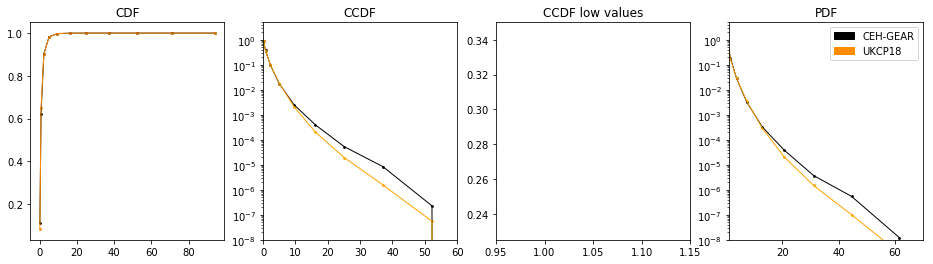

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_overlap_bin_edges, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_overlap_bin_edges,obs_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_overlap_bin_edges, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_overlap_bin_edges,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_overlap_bin_edges, obs_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_overlap_bin_edges,obs_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_overlap_bin_edges, model_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
axs[1].plot(model_overlap_bin_edges,model_overlap_ccdf ,linewidth = 1, color = 'orange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.95,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'orange')
axs[3].set_title('PDF')
axs[3].set_yscale('log')
axs[3].set_xlim(0.95,70)
axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

### Old regridding method

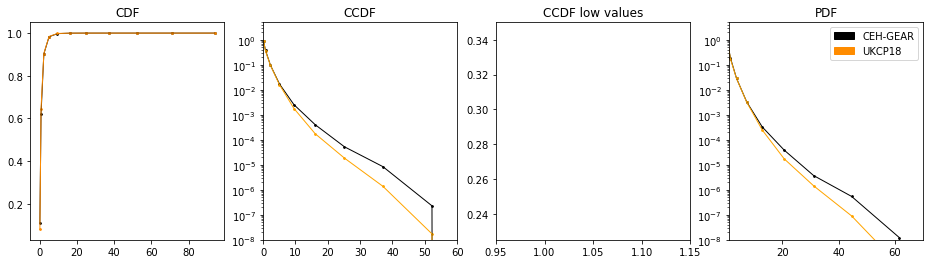

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_overlap_bin_edges, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_overlap_bin_edges,obs_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_overlap_bin_edges, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_overlap_bin_edges,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_overlap_bin_edges, obs_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_overlap_bin_edges,obs_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_overlap_bin_edges, model_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
axs[1].plot(model_overlap_bin_edges,model_overlap_ccdf ,linewidth = 1, color = 'orange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

axs[2].scatter(obs_overlap_bin_edges_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_overlap_bin_edges_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_overlap_bin_edges_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_overlap_bin_edges_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.95,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

axs[3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
axs[3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
axs[3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
axs[3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'orange')
axs[3].set_title('PDF')
axs[3].set_yscale('log')
axs[3].set_xlim(0.95,70)
axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

### Not overlapping data

Text(0.5,1,'CCDF low values')

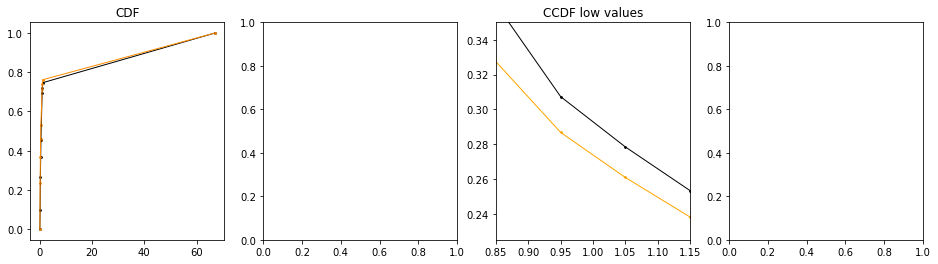

In [38]:
low_bins_i_want = [0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.95, 1.05, 1.15, np.nanmax(obs_data_overlap)]

obs_no_overlap_cdf_low, obs_no_overlap_ccdf_low, obs_no_overlap_bin_centres_low,  obs_no_overlap_bin_edges_low  = calculate_ccdf_wetvalues(obs_data_no_overlap, low_bins_i_want)
model_no_overlap_cdf_low, model_no_overlap_ccdf_low, model_no_overlap_bin_centres_low, model_no_overlap_bin_edges_low = calculate_ccdf_wetvalues(model_data_no_overlap,low_bins_i_want)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_no_overlap_bin_edges_low, obs_no_overlap_cdf_low ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_no_overlap_bin_edges_low,obs_no_overlap_cdf_low ,linewidth = 1, color = 'black')
axs[0].scatter(model_no_overlap_bin_edges_low, model_no_overlap_cdf_low ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_no_overlap_bin_edges_low,model_no_overlap_cdf_low ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[2].scatter(obs_no_overlap_bin_edges_low, obs_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_no_overlap_bin_edges_low,obs_no_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_no_overlap_bin_edges_low, model_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_no_overlap_bin_edges_low,model_no_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.85,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

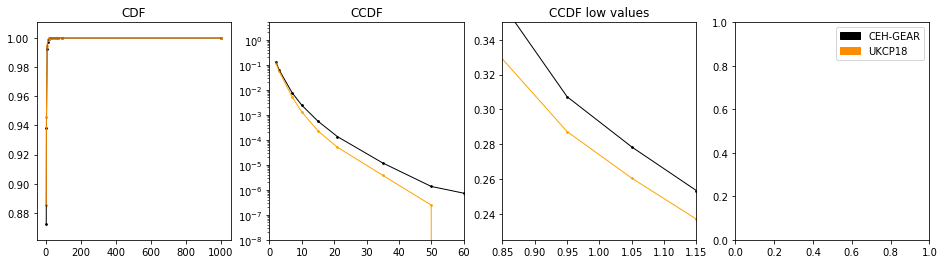

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
axs[0].scatter(obs_no_overlap_bin_edges, obs_no_overlap_cdf ,linewidth = 1,s=3, color = 'black')
axs[0].plot(obs_no_overlap_bin_edges,obs_no_overlap_cdf ,linewidth = 1, color = 'black')
axs[0].scatter(model_no_overlap_bin_edges, model_no_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
axs[0].plot(model_no_overlap_bin_edges,model_no_overlap_cdf ,linewidth = 1, color = 'darkorange')
axs[0].set_title('CDF')

axs[1].scatter(obs_no_overlap_bin_edges, obs_no_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
axs[1].plot(obs_no_overlap_bin_edges,obs_no_overlap_ccdf ,linewidth = 1, color = 'black')
axs[1].scatter(model_no_overlap_bin_edges, model_no_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
axs[1].plot(model_no_overlap_bin_edges,model_no_overlap_ccdf ,linewidth = 1, color = 'orange')
axs[1].set_yscale('log')
axs[1].set_xlim(0,60)
axs[1].set_ylim(1e-8,5)
axs[1].set_title('CCDF')

axs[2].scatter(obs_no_overlap_bin_edges_low, obs_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
axs[2].plot(obs_no_overlap_bin_edges_low,obs_no_overlap_ccdf_low ,linewidth = 1, color = 'black')
axs[2].scatter(model_no_overlap_bin_edges_low, model_no_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
axs[2].plot(model_no_overlap_bin_edges_low,model_no_overlap_ccdf_low ,linewidth = 1, color = 'orange')
axs[2].set_xlim(0.85,1.15)
axs[2].set_ylim(0.225,0.35)
axs[2].set_title('CCDF low values')

# axs[3].scatter(obs_no_overlap_bin_centres_pdf, obs_no_overlap_pdf ,linewidth = 1,s=3, color = 'black')
# axs[3].plot(obs_no_overlap_bin_centres_pdf,obs_no_overlap_pdf ,linewidth = 1, color = 'black')
# axs[3].scatter(model_ono_verlap_bin_centres_pdf, model_no_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
# axs[3].plot(model_no_overlap_bin_centres_pdf,model_no_overlap_pdf ,linewidth = 1, color = 'orange')
# axs[3].set_title('PDF')
# axs[3].set_yscale('log')
# axs[3].set_xlim(0.95,70)
# axs[3].set_ylim(1e-8,5)
axs[3].legend(handles=patches);

### Plot for each ensemble member separately

In [47]:
# ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']

# fig, axs = plt.subplots(nrows=12, ncols=4, figsize=(16,30))
# for ax_num, em in enumerate(ems):
#     model_data_overlap = np.array([])
#     model_data_no_overlap = np.array([])
    
#     print(em)
#     datadir = f'/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/1980_2001/{em}/'
#     for yr in range(1981,2001):
#         file_name = datadir + f"compressed_{yr}.npy"
#         this_yr = np.load(file_name)
#         model_data_no_overlap =np.append(model_data_no_overlap, this_yr)
#         if yr >=1990 and yr <=2001:
#             model_data_overlap =np.append(model_data_overlap, this_yr)
#     # bins_i_want =  [0.1, 0.5,2, 3, 7, 10,15, 21, 35,45, 62, 78]
#     obs_overlap_cdf, obs_overlap_ccdf, obs_overlap_bin_centres = calculate_ccdf_wetvalues(obs_data_overlap, bins_i_want)
#     model_overlap_cdf, model_overlap_ccdf, model_overlap_bin_centres = calculate_ccdf_wetvalues(model_data_overlap,bins_i_want)
    
#     axs[ax_num, 0].scatter(obs_overlap_bin_centres, obs_overlap_cdf ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 0].plot(obs_overlap_bin_centres,obs_overlap_cdf ,linewidth = 1, color = 'black')
#     axs[ax_num, 0].scatter(model_overlap_bin_centres, model_overlap_cdf ,linewidth = 1,s=3, color = 'darkorange')
#     axs[ax_num, 0].plot(model_overlap_bin_centres,model_overlap_cdf ,linewidth = 1, color = 'darkorange')
#     axs[ax_num, 0].set_title('CDF')

#     axs[ax_num, 1].scatter(obs_overlap_bin_centres, obs_overlap_ccdf ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 1].plot(obs_overlap_bin_centres,obs_overlap_ccdf ,linewidth = 1, color = 'black')
#     axs[ax_num, 1].scatter(model_overlap_bin_centres, model_overlap_ccdf ,linewidth = 1,s=3, color = 'orange')
#     axs[ax_num, 1].plot(model_overlap_bin_centres,model_overlap_ccdf ,linewidth = 1, color = 'orange')
#     axs[ax_num, 1].set_yscale('log')
#     axs[ax_num, 1].set_ylim(1e-8,5)
#     axs[ax_num, 1].set_title('CCDF')

#     axs[ax_num, 2].scatter(obs_overlap_bin_centres_low, obs_overlap_ccdf_low ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 2].plot(obs_overlap_bin_centres_low,obs_overlap_ccdf_low ,linewidth = 1, color = 'black')
#     axs[ax_num, 2].scatter(model_overlap_bin_centres_low, model_overlap_ccdf_low ,linewidth = 1,s=3, color = 'orange')
#     axs[ax_num, 2].plot(model_overlap_bin_centres_low,model_overlap_ccdf_low ,linewidth = 1, color = 'orange')
#     axs[ax_num, 2].set_title('CCDF low values')

#     axs[ax_num, 3].scatter(obs_overlap_bin_centres_pdf, obs_overlap_pdf ,linewidth = 1,s=3, color = 'black')
#     axs[ax_num, 3].plot(obs_overlap_bin_centres_pdf,obs_overlap_pdf ,linewidth = 1, color = 'black')
#     axs[ax_num, 3].scatter(model_overlap_bin_centres_pdf, model_overlap_pdf ,linewidth = 1,s=3, color = 'orange')
#     axs[ax_num, 3].plot(model_overlap_bin_centres_pdf,model_overlap_pdf ,linewidth = 1, color = 'orange')
#     axs[ax_num, 3].set_title('PDF')
#     axs[ax_num, 3].set_yscale('log')
#     axs[ax_num, 3].set_ylim(1e-8,5)
#     axs[ax_num, 3].legend(handles=patches);
